# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier


## Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [5]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [6]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Let's display patches for a sample image

XlaRuntimeError: Exception encountered when calling Patches.call().

[1mUNIMPLEMENTED: 
Can't lower one or more integer convolutions to idioms supported by CuDNN.

CuDNN integer convolutions must have:

  - s8 input and filter,
  - f32 bias (if present),
  - s8 or f32 output, and
  - s8 side_input (if present) if output is s8.

For each of the unsupported convs below, we weren't able to lower one of the
operands or the output to the appropriate type.

See specific HLO idioms in cudnn_fused_conv_rewriter.h, and see cudnn semantics:

https://docs.nvidia.com/deeplearning/cudnn/api/index.html#cudnnConvolutionBiasActivationForward and
https://docs.nvidia.com/deeplearning/cudnn/developer-guide/index.html#scaling-parameters

Unsupported convs:
 - %cudnn-conv = (u8[1,12,12,108]{3,2,1,0}, u8[0]{0}) custom-call(u8[1,72,72,3]{3,2,1,0} %Arg_0.1, u8[6,6,3,108]{3,2,1,0} %Arg_1.2), window={size=6x6 stride=6x6}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated" source_file="/usr/local/lib/python3.11/dist-packages/keras/src/backend/jax/nn.py" source_line=348}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

******* Full HLO module *******
HloModule jit_conv_general_dilated, entry_computation_layout={(u8[1,72,72,3]{3,2,1,0}, u8[6,6,3,108]{3,2,1,0})->u8[1,12,12,108]{3,2,1,0}}, allow_spmd_sharding_propagation_to_parameters={true,true}, allow_spmd_sharding_propagation_to_output={true}

ENTRY %main.4 (Arg_0.1: u8[1,72,72,3], Arg_1.2: u8[6,6,3,108]) -> u8[1,12,12,108] {
  %Arg_0.1 = u8[1,72,72,3]{3,2,1,0} parameter(0), metadata={op_name="args[0]"}
  %Arg_1.2 = u8[6,6,3,108]{3,2,1,0} parameter(1), metadata={op_name="args[1]"}
  %cudnn-conv = (u8[1,12,12,108]{3,2,1,0}, u8[0]{0}) custom-call(u8[1,72,72,3]{3,2,1,0} %Arg_0.1, u8[6,6,3,108]{3,2,1,0} %Arg_1.2), window={size=6x6 stride=6x6}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated" source_file="/usr/local/lib/python3.11/dist-packages/keras/src/backend/jax/nn.py" source_line=348}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
  ROOT %get-tuple-element = u8[1,12,12,108]{3,2,1,0} get-tuple-element((u8[1,12,12,108]{3,2,1,0}, u8[0]{0}) %cudnn-conv), index=0, metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated" source_file="/usr/local/lib/python3.11/dist-packages/keras/src/backend/jax/nn.py" source_line=348}
}


[0m

Arguments received by Patches.call():
  • images=jnp.ndarray(shape=(1, 72, 72, 3), dtype=uint8)

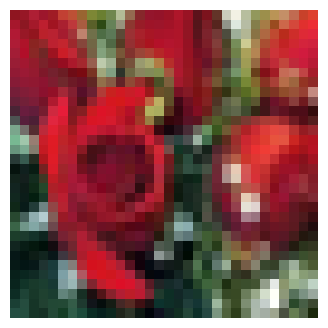

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [8]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [9]:

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.0291 - loss: 4.9091 - top-5-accuracy: 0.1127 - val_accuracy: 0.1038 - val_loss: 3.9542 - val_top-5-accuracy: 0.3138
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.0913 - loss: 3.9885 - top-5-accuracy: 0.2747 - val_accuracy: 0.1624 - val_loss: 3.5716 - val_top-5-accuracy: 0.4128
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.1241 - loss: 3.7291 - top-5-accuracy: 0.3525 - val_accuracy: 0.2060 - val_loss: 3.3152 - val_top-5-accuracy: 0.4788
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.1528 - loss: 3.5455 - top-5-accuracy: 0.4104 - val_accuracy: 0.2204 - val_loss: 3.1874 - val_top-5-accuracy: 0.5124
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.1813 - loss: 3.4022 - top-5-accuracy: 0.4540 - val_accuracy: 0.2478 - val_loss: 3.0556 - val_top-5-accuracy: 0.5500
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.2041 - loss: 3.257

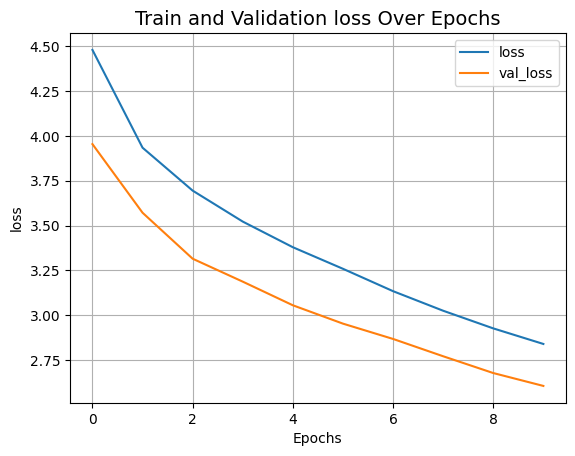

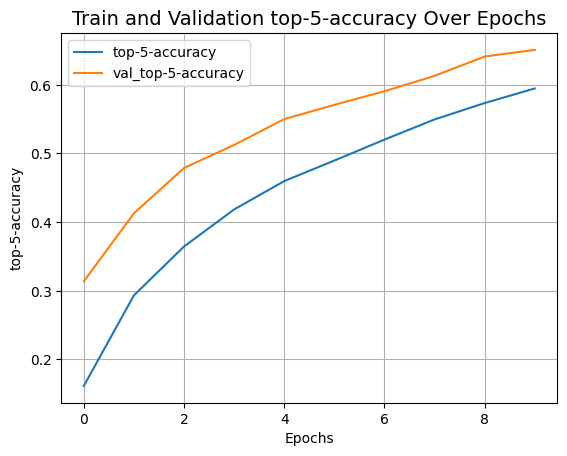

In [10]:

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")


After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions.
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices,
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step


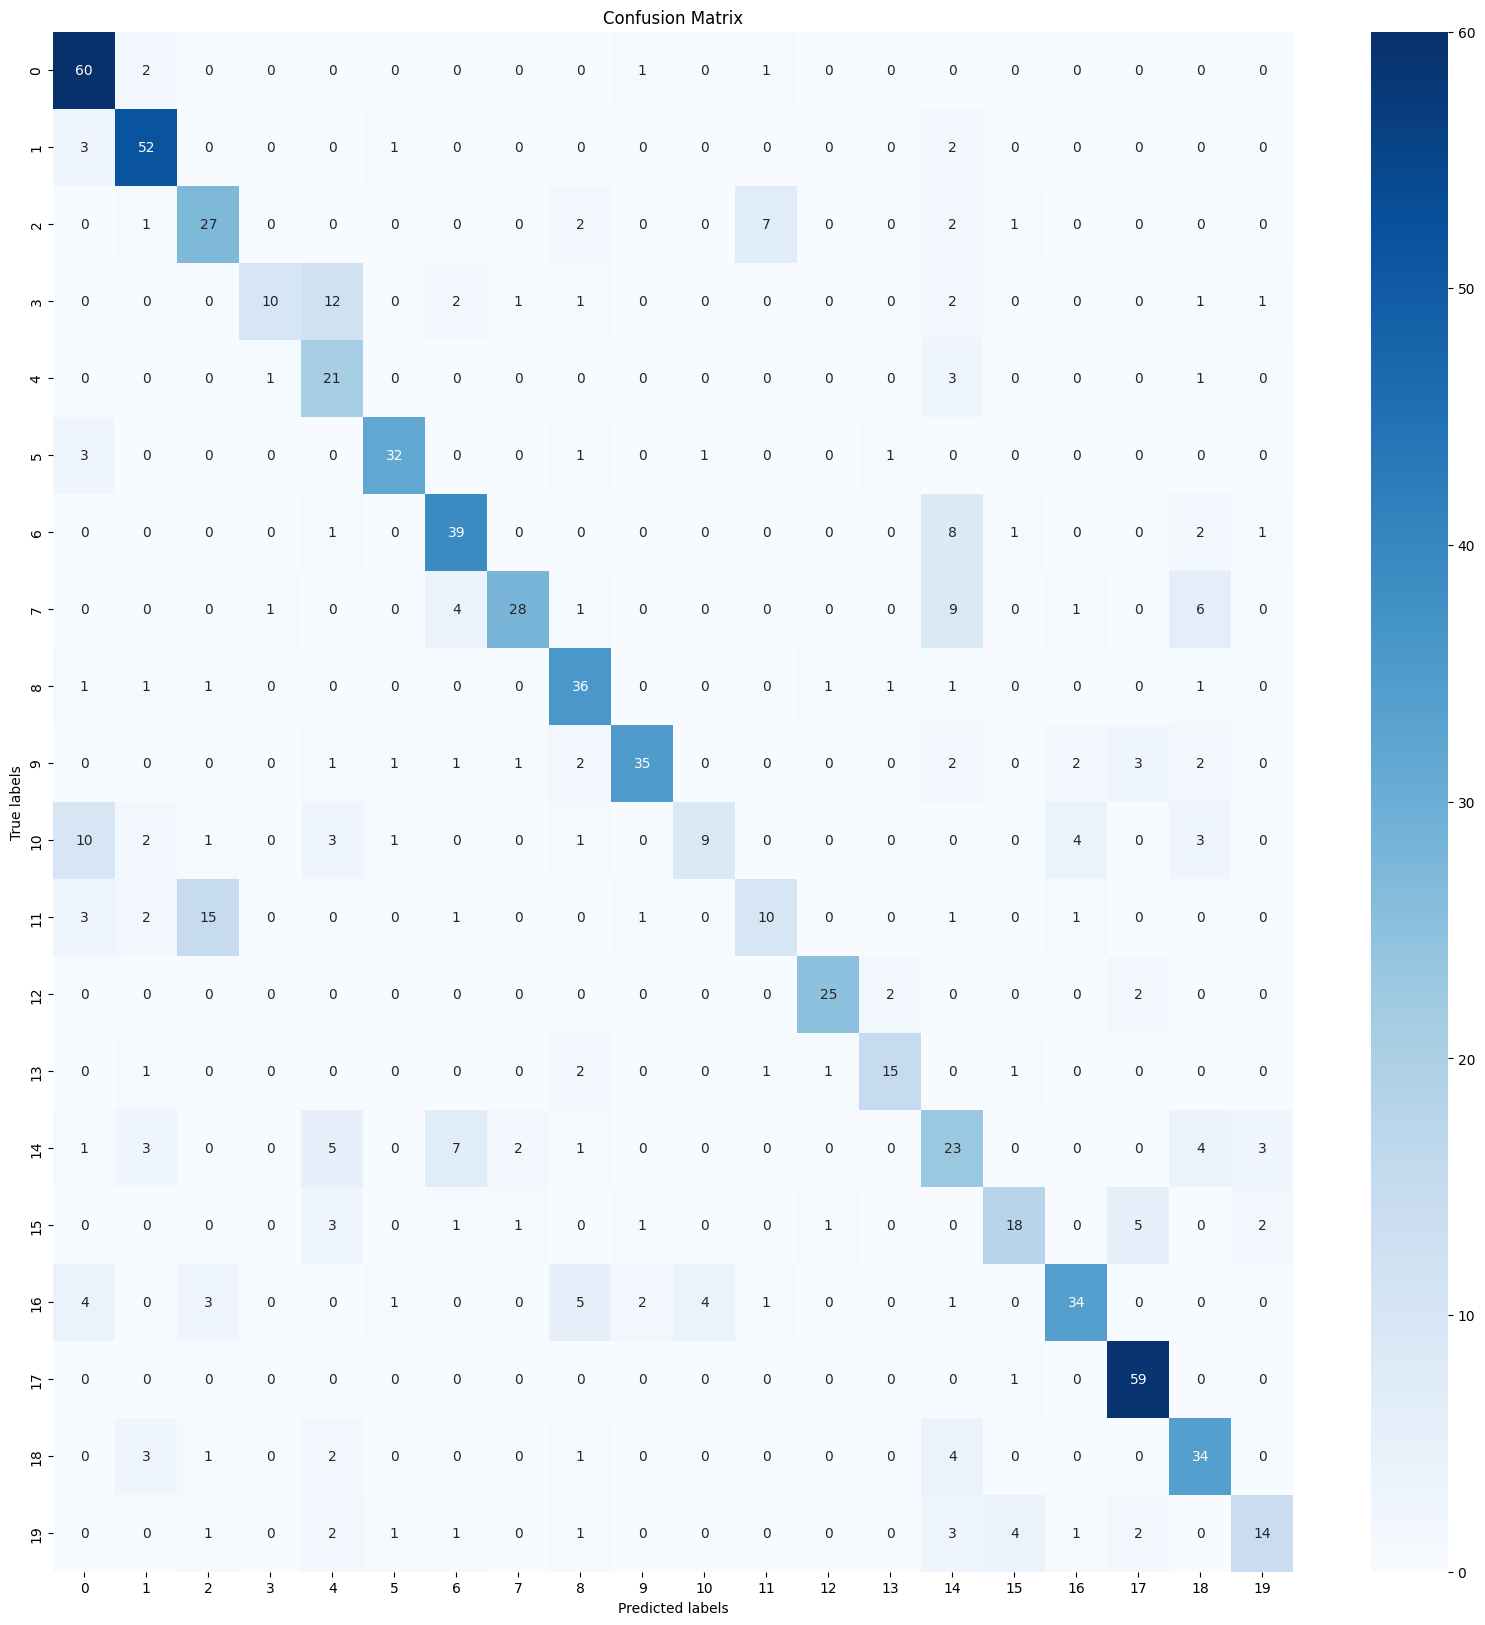

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions
model = vit_classifier
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix (for the first 20 classes to keep it readable)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat[:20, :20], annot=True, fmt='d', cmap='Blues',
            xticklabels=range(20), yticklabels=range(20))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.60      0.48       100
           1       0.37      0.52      0.43       100
           2       0.23      0.27      0.25       100
           3       0.45      0.10      0.16       100
           4       0.15      0.21      0.18       100
           5       0.32      0.32      0.32       100
           6       0.39      0.39      0.39       100
           7       0.64      0.28      0.39       100
           8       0.35      0.36      0.35       100
           9       0.55      0.35      0.43       100
          10       0.21      0.09      0.13       100
          11       0.30      0.10      0.15       100
          12       0.50      0.25      0.33       100
          13       0.38      0.15      0.21       100
          14       0.26      0.23      0.25       100
          15       0.28      0.18      0.22       100
          16       0.45      0.34      0.39       100
   